In [1]:
!pip install open-clip-torch

In [1]:
import csv
import numpy as np
import pandas as pd

train_csv_file_name = "/kaggle/input/digit-recognizer/train.csv"
test_csv_file_name = "/kaggle/input/digit-recognizer/test.csv"

height = 28
width = 28

train_data = pd.read_csv(train_csv_file_name)
x_train_data = train_data.drop('label', axis=1)
x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],height,width))
y_train_data = train_data['label']

test_data = pd.read_csv(test_csv_file_name)
x_test_data = np.reshape(test_data,(test_data.shape[0],height,width))

print(x_train_data.shape,y_train_data.shape, x_test_data.shape)

(42000, 28, 28) (42000,) (28000, 28, 28)


In [2]:
import torch
import open_clip
import os
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _,preprocess = open_clip.create_model_and_transforms('ViT-bigG-14', device=device,pretrained='laion2b_s39b_b160k')
model.to(device)
model.eval()
tokenizer = open_clip.get_tokenizer('ViT-bigG-14')

mnist_class = ['0','1','2','3','4','5','6','7','8','9']
mnist_template = 'a photo of the number: {}.'


In [37]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [3]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, images_array, label_array, transform):
        self.images_array = images_array
        self.label_array = label_array
        self.transform = transform
    
    def __len__(self):
        return self.images_array.shape[0]
    
    def __getitem__(self,index):
        img_array = self.images_array[index]
        image = Image.fromarray(img_array.astype(np.uint8))
        image = self.transform(image)
        label = -1
        if index <len(self.label_array):
            label = self.label_array[index]
        return image, label

In [4]:
@torch.no_grad()
def get_text_features():
    text_list = []
    for class_name in mnist_class:
        text = mnist_template.format(class_name) 
        text_list.append(text)
    text = tokenizer(text_list).to(device)
    text_embeddings = model.encode_text(text)
    text_embeddings / text_embeddings.norm(dim=-1,keepdim=True)
    return text_embeddings

In [5]:
train_dataset = ImageDataset(x_train_data,y_train_data,preprocess)
test_dataset = ImageDataset(x_test_data,[],preprocess)

train_dataloader = DataLoader(train_dataset, batch_size = 200, num_workers = 4)
test_dataloader = DataLoader(test_dataset, batch_size = 200, shuffle = False, num_workers=4)

In [6]:
from tqdm import tqdm

text_features = get_text_features()
count = 0
for images, labels in tqdm(train_dataloader):
    with torch.no_grad():
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1,keepdim=True)
        probs = (100. * image_features @ text_features.T).softmax(dim=-1).cpu()
        _, indexes = probs.topk(1,1,True,True)
    count+= np.sum(indexes.cpu().numpy().transpose()==labels.numpy())

print(count/len(train_dataloader))

100%|██████████| 210/210 [1:42:58<00:00, 29.42s/it]

129.66190476190476


In [8]:
print(count/x_train_data.shape[0])

0.6483095238095238


In [9]:
text_features = get_text_features()
label_res = np.empty((0,1))
for images, labels in tqdm(test_dataloader):
    with torch.no_grad():
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1,keepdim=True)
        probs = (100. * image_features @ text_features.T).softmax(dim=-1).cpu()
        _, indexes = probs.topk(1,1,True,True)
    
    label_res = np.hstack((label_res, indexes.cpu().numpy()))
    print(label_res)

submission_filename = "/kaggle/working/submission.csv"
with open(submission_filename,'w') as f:
    f.write("ImageId,Label\n")
    for index, label in enumerate(label_res):
        f.write(f"{index},{label}\n")

  0%|          | 0/140 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.57 GiB. GPU 0 has a total capacty of 15.89 GiB of which 1.05 GiB is free. Process 9167 has 14.84 GiB memory in use. Of the allocated memory 12.61 GiB is allocated by PyTorch, and 1.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<PIL.Image.Image image mode=L size=28x28 at 0x7D42EBC95270>


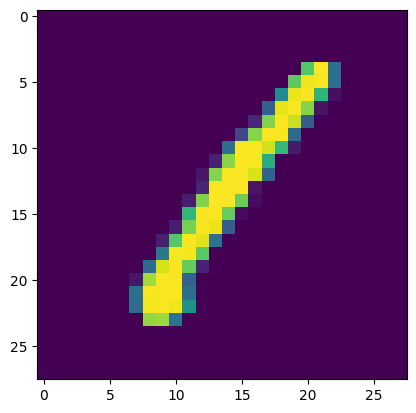

In [41]:
print(image)
plt.imshow(image)